In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from time import time
import numpy as np

print('Done')

Done


In [48]:

class ExhaustiveKNN(object):
    
    def __init__(self):
        return
    
    def fit(self, vecs):
        self.vecs = vecs
        
    def kneighbors_single(self, vec):
        nbrs = Counter()
        nb_ops = 0
        for i, vec_ in enumerate(self.vecs):
            for col, val in enumerate(vec):
                nbrs[i] += int(vec_[col] == vec[col])
                nb_ops += 1
        return nbrs, nb_ops

    def kneighbors(self, vecs):
        nb_ops = 0
        nbrs = []
        for vec in vecs:
            x = self.kneighbors_single(vec)
            nbrs.append(x[0])
            nb_ops += x[1]
        return nbrs, nb_ops
                

class IndexedKNN(object):
    
    def __init__(self):
        self.inv = defaultdict(list)
        self.nb_vecs = 0
    
    def fit(self, vecs):
        self.nb_vecs += len(vecs)
        for id_, vec in enumerate(vecs):
            for col, val in enumerate(vec):
                self.inv[(col, val)].append(id_)
                
    def kneighbors_single(self, vec):
        nbrs = Counter()
        nb_ops = 0
        for col, val in enumerate(vec):
            for id_ in self.inv[(col, val)]:
                nbrs[id_] += 1
                nb_ops += 1
        return nbrs, nb_ops
    
    def kneighbors(self, vecs):
        nb_ops = 0
        nbrs = []
        for vec in vecs:
            x = self.kneighbors_single(vec)
            nbrs.append(x[0])
            nb_ops += x[1]
        return nbrs, nb_ops


np.random.seed(1)
vecs = np.random.binomial(1, 0.5, (20, 5)).astype(np.uint8)
print(vecs[:2])

iknn = IndexedKNN()
iknn.fit(vecs)
inbrs, iops = iknn.kneighbors(vecs)

print('Mean values in each bucket = %d' % np.mean(list(map(len, iknn.inv.values()))))


eknn = ExhaustiveKNN()
eknn.fit(vecs)
enbrs, eops = eknn.kneighbors(vecs)

for i in range(len(vecs)):
    print('Pass' if inbrs[i].most_common() == enbrs[i].most_common()[:len(inbrs[i])] else 'Fail')

[[0 1 0 0 0]
 [0 0 0 0 1]]
Mean values in each bucket = 10
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass
Pass


1 (1310, 0.0024) (2560, 0.0056)
2 (2580, 0.0033) (5120, 0.0102)
3 (5208, 0.0050) (10240, 0.0194)
4 (10426, 0.0085) (20480, 0.0389)
5 (20808, 0.0157) (40960, 0.0765)
6 (41580, 0.0302) (81920, 0.1466)


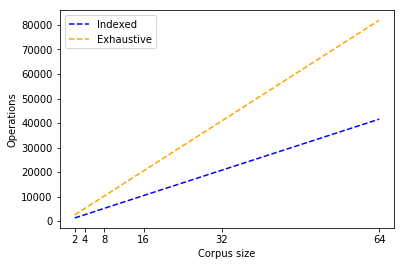

In [32]:
xvals, times_indexed, times_exhaustive, ops_indexed, ops_exhaustive = [], [], [], [], []
base = 2
max_exp = 7
np.random.seed(1)
vecs = np.random.binomial(1, 0.5, (base ** max_exp, 10)).astype(np.uint8)

for exp in range(1, max_exp):  
    xvals.append(base ** exp)
    
    iknn = IndexedKNN()
    iknn.fit(vecs[: base**exp])
    t0 = time()
    ops_indexed.append(iknn.kneighbors(vecs)[1])
    times_indexed.append(time() - t0)
    
    eknn = ExhaustiveKNN()
    eknn.fit(vecs[: base**exp])
    t0 = time()
    ops_exhaustive.append(eknn.kneighbors(vecs)[1])
    times_exhaustive.append(time() - t0)

    print('%d (%d, %.4lf) (%d, %.4lf)' % (
        exp, ops_indexed[-1], times_indexed[-1], ops_exhaustive[-1], times_exhaustive[-1]))
    
plt.plot(xvals, ops_indexed, label='Indexed', color='blue', linestyle='--')
plt.plot(xvals, ops_exhaustive, label='Exhaustive', color='orange', linestyle='--')
plt.xticks(xvals)
plt.xlabel('Corpus size')
plt.ylabel('Operations')
plt.legend()
plt.show()

Runtime complexity for KNN with $n$ corpus vectors and $n$ query vectors with dimension $d$.

For exhaustive implementation: $O(n^2 \times d)$

For inverted-index implementation: $O(n^2 \times d \diagup 2)$, assuming $P(\text{hash} = 1) = 0.5$. This becomes intuitive when you consider that at each index in the vector, you have to iterate over half of the corpus to increment their counts.

In [6]:
# Complexity for implementation with L different random initializations, each based on K hyperplanes..
from math import log

def O_partial_sort(K, N):
    return N * log(N) # TODO... what is the actual *partial* complexity?

def O_query(N, D, L, H, K):
    O = 1
    O *= L           # Once for each LSH configuration.
    O *= N           # Once for each of the N vectors.
    O *= D           # Once for each dimension.
    O *= (N / 2**H)  # Once for each vector in this hash bucket; there are 2**K buckets.
    O += O_partial_sort(K, L * N / 2**K)
    return O
    
    
# O_query = lambda N, D, L, H, K: (L * N * D * (N / 2**H)) # + O_sort(L * N / 2**H)

N = 1000000      # No. items in corpus.
D = 2048         # Original dimensionality of item vectors.
L = 99            # No. randomly-initialized LSH configurations.
H = 32           # No. binary bits for each LSH configuration, also no. hyperplanes.
K = 10           # Get the top K.

print("Brute force full KNN = %d operations" % (N * N * D))
print("Approximate full KNN = %d operations" % O_query(N, D, L, H, K))
print("Gains = %dx" % (N * N * D / O_query(N, D, L, H, K)))

Brute force full KNN = 2048000000000000 operations
Approximate full KNN = 48316680 operations
Gains = 42387018x
